# Automatic classification of eclipsing binary stars using deep learning methods

> Vstupne datasety (single_spotty.pkl, overcontact_bellow_i_crit.pkl) boli vytvorene pomocou binaries_single_spotty.ipynb a binaries_overcontact_bellow_i_crit_10000.ipynb

Experiment 1:

- datasety: single_spotty (6 853)
              overcontact_bellow_i_crit (55 914) 
- vstup do modelu: concat 5 kriviek (BRUVI)
- šum: stochastic_noise_generator
- train_test_split: test_size=0.2
- výstup modelu: klasifikacia 0 -> detached, 
                            1 -> overcontact
- evaluácia: concat 5 kriviek test (BRUVI), nad 0.5 -> 1
- checkpoint: monitor: val_acc, mode: max


Experiment 2:
 
- datasety: single_spotty (6 853)
              overcontact_bellow_i_crit (55 914)  
- vstup do modelu: 1 typ kriviek (U) 
- šum: stochastic_noise_generator
- train_test_split: test_size=0.2
- výstup modelu: klasifikacia 0 -> detached, 
                            1 -> overcontact
- evaluácia: po jednom krivky (BRUVI), nad 0.5 -> 1
- checkpoint: monitor: val_acc, mode: max


Experiment 3:

- datasety: single_spotty (6 853)
              overcontact_bellow_i_crit (55 914) 
- vstup do modelu: krivky (BRUVI) spojene do jedneho datasetu
- šum: stochastic_noise_generator
- train_test_split: test_size=0.2
- výstup modelu: klasifikacia 0 -> detached, 
                            1 -> overcontact
- evaluácia: krivky (BRUVI) spojene do jedneho datasetu, nad 0.5 -> 1
- checkpoint: monitor: val_acc, mode: max


In [29]:
import numpy as np
import pandas as pd
import json
import pickle
np.random.seed(1234)

from noise_generator import stochastic_noise_generator
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import Input, Dense, concatenate, Activation, LSTM, Bidirectional, Flatten, Dropout
from keras.models import Model
from keras.models import Sequential
from keras.layers.merge import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

import imblearn
from imblearn import under_sampling, over_sampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

import scikitplot as skplt

In [3]:
# V pripade ak boli chyby s importami, tak je potrebne to spustit (robi sa so zdielanymi prostrediami)

# %pip install keras
# %pip install elisa
# %pip install imblearn
# %pip install --upgrade tensorflow
# %pip install --upgrade tensorflow-gpu
# %pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 497.6 MB 2.6 kB/s  eta 0:00:01
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
     |████████████████████████████████| 16.8 MB 69.5 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 64.0 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalling tensorflow-2.7.0:
      Successfully uninstalled tensorflow-2.7.0
ERROR: pip's dependency resolver does not currently take into accoun

## Data load

- load synthetic light curve - ELISa
- Loads previously prepared data,

In [3]:
data_overcontact_0 = pd.read_pickle("single_spotty.pkl")
data_overcontact_0.head(1)

,id,Bessell_U,Bessell_B,Bessell_V,Bessell_R,Bessell_I,overcontact
0,1,"[0.999723147256461, 0.9998263845312357, 0.9999...","[0.999729147335103, 0.9998341245757354, 0.9999...","[0.9997193606202365, 0.9998297654831404, 0.999...","[0.9997101293497717, 0.9998251315085762, 0.999...","[0.9996999473946334, 0.9998205539859434, 0.999...",0


In [4]:
data_overcontact_1 = pd.read_pickle("overcontact_bellow_i_crit.pkl")
data_overcontact_1.head(1)

,id,Bessell_U,Bessell_B,Bessell_V,Bessell_R,Bessell_I,overcontact
0,5523148,"[1.0, 0.9999997307325279, 0.9999993208745404, ...","[1.0, 0.9999997333725458, 0.9999993854857628, ...","[1.0, 0.9999997522458502, 0.9999994904106757, ...","[1.0, 0.9999997580790063, 0.9999995484215244, ...","[1.0, 0.9999997080162979, 0.9999995299493861, ...",1


In [5]:
data = pd.concat([data_overcontact_0, data_overcontact_1])
data.head(1)

,id,Bessell_U,Bessell_B,Bessell_V,Bessell_R,Bessell_I,overcontact
0,1,"[0.999723147256461, 0.9998263845312357, 0.9999...","[0.999729147335103, 0.9998341245757354, 0.9999...","[0.9997193606202365, 0.9998297654831404, 0.999...","[0.9997101293497717, 0.9998251315085762, 0.999...","[0.9996999473946334, 0.9998205539859434, 0.999...",0


### Check data 

In [6]:
data.dtypes

id              int64
Bessell_U      object
Bessell_B      object
Bessell_V      object
Bessell_R      object
Bessell_I      object
overcontact     int64
dtype: object

In [7]:
data['overcontact'].value_counts()

1    55914
0     6853
Name: overcontact, dtype: int64

## Data preparation
- train_test_split
- bessel_to_array -> comma seperated string transforms to array
- add noice to train and test sets
> musi to byt v tomto poradi lebo ked sa aplikuje noice tak uz nejde urobit train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, data['overcontact'], test_size=0.2, random_state=42)

# Check shapes after split
print(X_train.shape)
print("########")
print(y_train)
print("########")
print(X_test.shape)
print("########")
print(y_test)
print("########")

(50213, 7)
########
11397    1
53339    1
16667    1
1430     0
11020    1
        ..
55717    1
31305    1
860      0
8942     1
49569    1
Name: overcontact, Length: 50213, dtype: int64
########
(12554, 7)
########
55571    1
30257    1
46707    1
52254    1
5253     0
        ..
13462    1
12378    1
50311    1
53954    1
11722    1
Name: overcontact, Length: 12554, dtype: int64
########


In [9]:
def bessel_to_array(column_name, df):
    """Model expects array input. 
    This function transforms all curves in 1 column (400 comma seperated numbers) to array"""
    newData_bessell = []
    for row in df[column_name]:
        newRow = []
        for valueIndex in range(len(row)):
            newRow.append([row[valueIndex]])
        newData_bessell.append(newRow) 
    newData_bessell = np.array(newData_bessell)
    return newData_bessell

In [10]:
X_train_with_arrays_noise = []
for column in ['Bessell_U','Bessell_B','Bessell_V','Bessell_R','Bessell_I']:
    X_train_with_arrays_noise.append(stochastic_noise_generator(bessel_to_array(column, X_train)))
    print(column + " " + "prossessed")

Bessell_U prossessed
Bessell_B prossessed
Bessell_V prossessed
Bessell_R prossessed
Bessell_I prossessed


In [11]:
X_test_with_arrays_noise = []
for column in ['Bessell_U','Bessell_B','Bessell_V','Bessell_R','Bessell_I']:
    X_test_with_arrays_noise.append(stochastic_noise_generator(bessel_to_array(column, X_test)))
    print(column + " " + "prossessed")

Bessell_U prossessed
Bessell_B prossessed
Bessell_V prossessed
Bessell_R prossessed
Bessell_I prossessed


In [12]:
# (5, 2, 16000, 400, 1) -> meaning: 
# 5 - UBVRI
# 16000 - number of curves
# 400 - size of 1 curve
# 1 - detached or overcontact

print(np.array(X_train_with_arrays_noise).shape)
print(np.array(X_test_with_arrays_noise).shape)

(5, 2, 50213, 400, 1)
(5, 2, 12554, 400, 1)


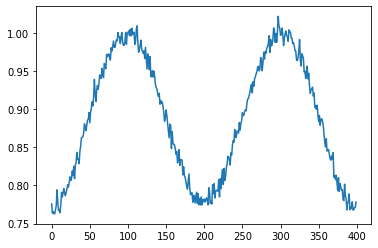

In [13]:
# Check if noice was added successfully
plt.plot(X_train_with_arrays_noise[1][0][1500])

In [14]:
# Check if U,B,V,R,I version of the same curve with noice is different
print(np.array_equal(X_train_with_arrays_noise[0][0], X_train_with_arrays_noise[1][0]))
print(np.array_equal(X_train_with_arrays_noise[1][0], X_train_with_arrays_noise[2][0]))
print(np.array_equal(X_train_with_arrays_noise[2][0], X_train_with_arrays_noise[3][0]))
print(np.array_equal(X_train_with_arrays_noise[3][0], X_train_with_arrays_noise[4][0]))

False
False
False
False


In [15]:
# target is overcontact
target = np.array(y_train)
print(target)

# just to be sure that both types are in dataset
exists = 0 in target
print(exists)
exists = 1 in target
print(exists)

[1 1 1 ... 0 1 1]
True
True


> Control the shape and check if the dataset is imbalanced (ale nacital som si z oboch 10 000 cize viem ze by mal byt vyvazeny)

In [16]:
print(target.shape)

print(X_train_with_arrays_noise[0][0].shape)
print(X_train_with_arrays_noise[1][0].shape)
print(X_train_with_arrays_noise[2][0].shape)
print(X_train_with_arrays_noise[3][0].shape)
print(X_train_with_arrays_noise[4][0].shape)

print(Counter(target))

(50213,)
(50213, 400, 1)
(50213, 400, 1)
(50213, 400, 1)
(50213, 400, 1)
(50213, 400, 1)
Counter({1: 44693, 0: 5520})


    - fit and apply the transform

In [17]:
def print_shape_counter(column, target):
    print(column.shape)
    print(target.shape)
    print(Counter(target))

In [18]:
for i in range(5):
    print_shape_counter(X_train_with_arrays_noise[i][0], y_train)
    print("")

(50213, 400, 1)
(50213,)
Counter({1: 44693, 0: 5520})

(50213, 400, 1)
(50213,)
Counter({1: 44693, 0: 5520})

(50213, 400, 1)
(50213,)
Counter({1: 44693, 0: 5520})

(50213, 400, 1)
(50213,)
Counter({1: 44693, 0: 5520})

(50213, 400, 1)
(50213,)
Counter({1: 44693, 0: 5520})



In [19]:
# transform to categorical
y_train = np_utils.to_categorical(y_train, 2)
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [20]:
#Check shape 
print(np.array(X_train_with_arrays_noise).shape)
print(y_train.shape)
print((y_train))

(5, 2, 50213, 400, 1)
(50213, 2)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


# Multiple models
> always choose only one

## experiment 1 -> biLSTM + CNN

In [22]:
inputU = Input(shape=(400,1))
inputB = Input(shape=(400,1))
inputV = Input(shape=(400,1))
inputR = Input(shape=(400,1))
inputI = Input(shape=(400,1))

u = Bidirectional(LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(inputU)
u = Flatten()(u)
u = Model(inputs=inputU, outputs=u)
u1 = Conv1D(32, kernel_size = 3, padding = "valid", input_shape=(400,1))(inputU)
u1 = MaxPooling1D(2)(u1)
u1 = Conv1D(32, kernel_size = 3, padding = "valid")(u1)
u1 = MaxPooling1D(2)(u1)
u1 = Flatten()(u1)
u1 = Model(inputs=inputU, outputs=u1)

b = Conv1D(32, kernel_size = 3, padding = "valid", input_shape=(400,1))(inputB)
b = MaxPooling1D(2)(b)
b = Conv1D(32, kernel_size = 3, padding = "valid")(b)
b = MaxPooling1D(2)(b)
b = Flatten()(b)
b = Model(inputs=inputB, outputs=b)

v = Bidirectional(LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(inputV)
v = Flatten()(v)
v = Model(inputs=inputV, outputs=v)

r = Bidirectional(LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(inputR)
r = Flatten()(r)
r = Model(inputs=inputR, outputs=r)

i = Bidirectional(LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(inputI)
i = Flatten()(i)
i = Model(inputs=inputI, outputs=i)

x = concatenate([u.output, u1.output, b.output,v.output,r.output,i.output])
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

classifier = Model(inputs=[u.input, b.input, v.input, r.input, i.input ], outputs=output)
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(classifier.summary())

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 1)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 400, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 398, 32)      128         ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 398, 32)      128         ['input_2[0][0]']                
                                                                                            

In [23]:
# checkpoint: save only best model

saved_model = "model_experiment_1.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=3)
callbacks_list = [checkpoint, early]

### Training  
UBVRI version of the same curve as input

In [24]:
history = classifier.fit([X_train_with_arrays_noise[0][0],
                          X_train_with_arrays_noise[1][0],
                          X_train_with_arrays_noise[2][0],
                          X_train_with_arrays_noise[3][0],
                          X_train_with_arrays_noise[4][0]], y_train, 
                         validation_split=0.1, epochs=3, batch_size=128, verbose=1, callbacks = callbacks_list)

Epoch 1/3
354/354 [==============================] - ETA: 0s - loss: 0.4169 - acc: 0.8813
Epoch 00001: val_acc improved from -inf to 0.61987, saving model to model_experiment_1.hdf5
354/354 [==============================] - 445s 1s/step - loss: 0.4169 - acc: 0.8813 - val_loss: 0.5542 - val_acc: 0.6199
Epoch 2/3
354/354 [==============================] - ETA: 0s - loss: 0.2653 - acc: 0.8925
Epoch 00002: val_acc improved from 0.61987 to 0.89685, saving model to model_experiment_1.hdf5
354/354 [==============================] - 430s 1s/step - loss: 0.2653 - acc: 0.8925 - val_loss: 0.2407 - val_acc: 0.8969
Epoch 3/3
354/354 [==============================] - ETA: 0s - loss: 0.2392 - acc: 0.8987
Epoch 00003: val_acc improved from 0.89685 to 0.90143, saving model to model_experiment_1.hdf5
354/354 [==============================] - 429s 1s/step - loss: 0.2392 - acc: 0.8987 - val_loss: 0.2161 - val_acc: 0.9014


## experiment 2 -> biLSTM + CNN

In [25]:
inputs = Input(shape=(400,1))

a = Bidirectional(LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(inputs)
a = Flatten()(a)

b = Conv1D(32, kernel_size = 3, padding = "valid", input_shape=(400,1))(inputs)
b = MaxPooling1D(2)(b)
b = Conv1D(32, kernel_size = 3, padding = "valid")(b)
b = MaxPooling1D(2)(b)
b = Flatten()(b)

x = concatenate([a,b])
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)

output = Dense(2, activation='softmax')(x)
classifier = Model(inputs=inputs, outputs=output)
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(classifier.summary())

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 400, 1)]     0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 398, 32)      128         ['input_6[0][0]']                
                                                                                                  
 max_pooling1d_4 (MaxPooling1D)  (None, 199, 32)     0           ['conv1d_4[0][0]']               
                                                                                                  
 conv1d_5 (Conv1D)              (None, 197, 32)      3104        ['max_pooling1d_4[0][0]']        
                                                                                            

In [26]:
saved_model = "model_experiment_2.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=3)
callbacks_list = [checkpoint, early]

In [27]:
history = classifier.fit(X_train_with_arrays_noise[0][0], y_train, validation_split=0.2, epochs=5, batch_size=128, verbose=1, callbacks = callbacks_list)

Epoch 1/5
314/314 [==============================] - ETA: 0s - loss: 0.3481 - acc: 0.8904
Epoch 00001: val_acc improved from -inf to 0.88828, saving model to model_experiment_2.hdf5
314/314 [==============================] - 134s 414ms/step - loss: 0.3481 - acc: 0.8904 - val_loss: 0.2906 - val_acc: 0.8883
Epoch 2/5
314/314 [==============================] - ETA: 0s - loss: 0.2739 - acc: 0.8937
Epoch 00002: val_acc improved from 0.88828 to 0.89356, saving model to model_experiment_2.hdf5
314/314 [==============================] - 127s 406ms/step - loss: 0.2739 - acc: 0.8937 - val_loss: 0.2479 - val_acc: 0.8936
Epoch 3/5
314/314 [==============================] - ETA: 0s - loss: 0.2550 - acc: 0.8976
Epoch 00003: val_acc improved from 0.89356 to 0.89366, saving model to model_experiment_2.hdf5
314/314 [==============================] - 127s 404ms/step - loss: 0.2550 - acc: 0.8976 - val_loss: 0.2455 - val_acc: 0.8937
Epoch 4/5
314/314 [==============================] - ETA: 0s - loss: 0.20

## experiment 3 -> same model as experiment 2

In [28]:
saved_model = "model_experiment_3.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=3)
callbacks_list = [checkpoint, early]

In [29]:
x_train = np.concatenate((X_train_with_arrays_noise[0][0],
                          X_train_with_arrays_noise[1][0], 
                          X_train_with_arrays_noise[2][0], 
                          X_train_with_arrays_noise[3][0],
                          X_train_with_arrays_noise[4][0])) 

In [30]:
y_train_mixed = np.concatenate((y_train,
                                y_train, 
                                y_train, 
                                y_train,
                                y_train)) 

In [31]:
history = classifier.fit(x_train, y_train_mixed, validation_split=0.2, epochs=5, batch_size=128, verbose=1, callbacks = callbacks_list)

Epoch 1/5
1570/1570 [==============================] - ETA: 0s - loss: 0.1432 - acc: 0.9301
Epoch 00001: val_acc improved from -inf to 0.96121, saving model to model_experiment_3.hdf5
1570/1570 [==============================] - 633s 403ms/step - loss: 0.1432 - acc: 0.9301 - val_loss: 0.1033 - val_acc: 0.9612
Epoch 2/5
1570/1570 [==============================] - ETA: 0s - loss: 0.0998 - acc: 0.9512
Epoch 00002: val_acc did not improve from 0.96121
1570/1570 [==============================] - 632s 402ms/step - loss: 0.0998 - acc: 0.9512 - val_loss: 0.0911 - val_acc: 0.9550
Epoch 3/5
1570/1570 [==============================] - ETA: 0s - loss: 0.0944 - acc: 0.9541
Epoch 00003: val_acc did not improve from 0.96121
1570/1570 [==============================] - 632s 402ms/step - loss: 0.0944 - acc: 0.9541 - val_loss: 0.0859 - val_acc: 0.9571
Epoch 4/5
1570/1570 [==============================] - ETA: 0s - loss: 0.0941 - acc: 0.9543
Epoch 00004: val_acc did not improve from 0.96121
1570/1570

In [ ]:
saved_model = "model_experiment_4.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
x_train = np.concatenate((X_train_with_arrays_noise[0][0],
                          X_train_with_arrays_noise[1][0], 
                          X_train_with_arrays_noise[2][0], 
                          X_train_with_arrays_noise[3][0],
                          X_train_with_arrays_noise[4][0])) 

In [ ]:
y_train_mixed = np.concatenate((y_train,
                                y_train, 
                                y_train, 
                                y_train,
                                y_train)) 

In [ ]:
history = classifier.fit(x_train, y_train_mixed, validation_split=0.2, epochs=5, batch_size=128, verbose=1, callbacks = callbacks_list)

In [13]:
# Define function for plot loss and accuracy during training
def trainingLoss(history):
    plt.style.use('ggplot')
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('tarin1.png', bbox_inches='tight')
    plt.show()
    plt.style.use('ggplot')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('tarin2.png', )
    plt.show()

Plot training graphs

In [14]:
trainingLoss(history)

NameError: name 'history' is not defined

# Model experiment 1 evaluation

In [25]:
def evaluate_all(model_path, input_data, y_test):
    classifier = load_model(model_path)
    # y_pred returns probability of detached and overcontact 
    # for example [1.4059671e-04, 9.9985933e-01], 
    # means detached with prob. 0.0001405  and overcontact with prob 0.998
    y_pred = classifier.predict(input_data)
    # print(y_pred)
    
    # for example [1.4059671e-04, 9.9985933e-01] -> [0, 1], it is marked as detached 
    y_pred2 = np.where(y_pred > 0.5, 1, 0)
    
    # test data [0,1,...] is converted to categorical [[0,1],[1,0]]
    target_test = np.array(y_test)
    target_test = np_utils.to_categorical(target_test, 2)
    
    # confusion matrix -old 
    # cm = confusion_matrix(target_test.argmax(axis=1), y_pred2.argmax(axis=1))
    # print("Confusion matrix: \n" + str(cm))
    
    # confusion matrix - nice print 
    matrix=skplt.metrics.plot_confusion_matrix(target_test.argmax(axis=1), y_pred2.argmax(axis=1))
    matrix.xaxis.set_ticklabels(['single spotty', 'overcontact'])
    matrix.yaxis.set_ticklabels(['single spotty', 'overcontact'])
    matrix
    
    target_names= ['single spotty', 'overcontact']
    print("Classification report: \n" + classification_report(target_test.argmax(axis=1), y_pred2.argmax(axis=1),target_names=target_names))

    # from categorical [0, 1] -> 1
    y_true = target_test.argmax(axis=1)
    
    skplt.metrics.plot_roc(y_true, y_pred)
    plt.savefig('roc_auc.png')
    plt.show()
    
    input_data = np.array(input_data)
    
    
    limit_plot=0
    for j in range(len(y_pred2)): 
        if (y_pred2[j].argmax(axis=0) == 1) and (target_test[j].argmax(axis=0) == 0):
            if input_data.ndim == 4:
                plt.plot(input_data[0][j],label = str(y_test.iloc[[j]].index[0]) + ", " +str(y_test.iloc[[j]].values[0]))
                fig1 = plt.figure(1)
                fig1.text(0.45, 0.9, "single spotty 0", ha="center", va="bottom", color="green")
                fig1.text(0.53, 0.9, "/", ha="center", va="bottom",  color="black")
                fig1.text(0.62, 0.9, "overcontact 1", ha="center", va="bottom",  color="red")
                limit_plot=limit_plot+1
            else:
                plt.plot(input_data[j],label = str(y_test.iloc[[j]].index[0]) + ", " +str(y_test.iloc[[j]].values[0]))
                fig1 = plt.figure(1)
                fig1.text(0.45, 0.9, "single spotty 0", ha="center", va="bottom" ,color="green")
                fig1.text(0.53, 0.9, "/", ha="center", va="bottom",  color="black")
                fig1.text(0.62,0.9, "overcontact 1", ha="center", va="bottom",  color="red")
                limit_plot=limit_plot+1
            if limit_plot == 2:
                break 

    
    plt.legend(loc='upper right')       
    plt.savefig('image.png')
    plt.show()     


    limit_plot2=0
    for j in range(len(y_pred2)): 
        if (y_pred2[j].argmax(axis=0) == 0) and (target_test[j].argmax(axis=0) == 1):
            if input_data.ndim == 4:
                plt.plot(input_data[0][j],label = str(y_test.iloc[[j]].index[0]) + ", " +str(y_test.iloc[[j]].values[0]))
                fig1 = plt.figure(1)
                fig1.text(0.45, 0.9, "single spotty 0", ha="center", va="bottom", color="red")
                fig1.text(0.53, 0.9, "/", ha="center", va="bottom",  color="black")
                fig1.text(0.62, 0.9, "overcontact 1", ha="center", va="bottom",  color="green")
                limit_plot2=limit_plot2+1
                
            else:
                plt.plot(input_data[j],label = str(y_test.iloc[[j]].index[0]) + ", " +str(y_test.iloc[[j]].values[0]))
                fig1 = plt.figure(1)
                fig1.text(0.45, 0.9, "single spotty 0", ha="center", va="bottom", color="red")
                fig1.text(0.53, 0.9, "/", ha="center", va="bottom",  color="black")
                fig1.text(0.62, 0.9, "overcontact 1", ha="center", va="bottom",  color="green")
                limit_plot2=limit_plot2+1
            if limit_plot2 == 2:
                break 
    
    plt.legend(loc='upper right')       
    plt.savefig('image2.png')
    plt.show()

(12554,)
Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.13      0.23      1333
           1       0.91      1.00      0.95     11221

    accuracy                           0.91     12554
   macro avg       0.95      0.56      0.59     12554
weighted avg       0.92      0.91      0.87     12554



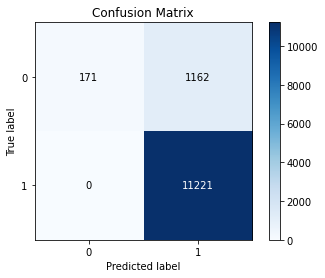

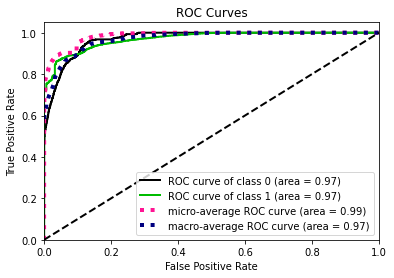

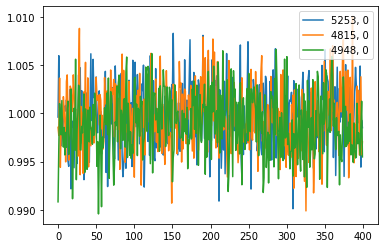

2022-02-07 10:11:02,845 - 666 - matplotlib.legend - WARNING: No handles with labels found to put in legend.


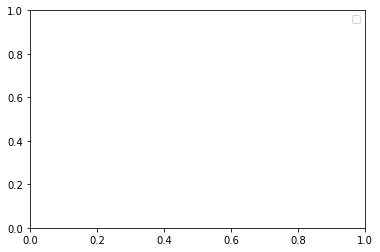

In [26]:
processed_test_data=[
 X_test_with_arrays_noise[0][0],
 X_test_with_arrays_noise[1][0],
 X_test_with_arrays_noise[2][0],
 X_test_with_arrays_noise[3][0],
 X_test_with_arrays_noise[4][0]]

print(y_test.shape)

evaluate_all('model_experiment_1.hdf5', processed_test_data, y_test)

# Model 2 evaluation

(12554,)
(5, 12554, 400, 1)
Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.20      0.34      1333
           1       0.91      1.00      0.95     11221

    accuracy                           0.92     12554
   macro avg       0.96      0.60      0.65     12554
weighted avg       0.92      0.92      0.89     12554



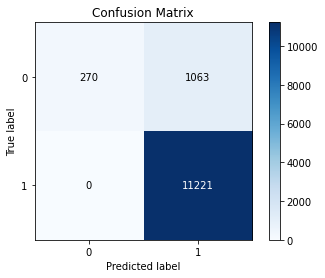

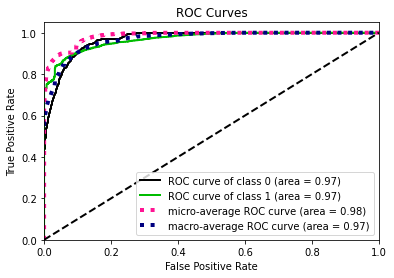

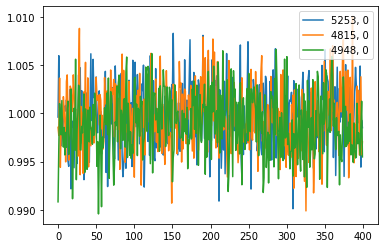

2022-02-07 10:11:35,727 - 666 - matplotlib.legend - WARNING: No handles with labels found to put in legend.


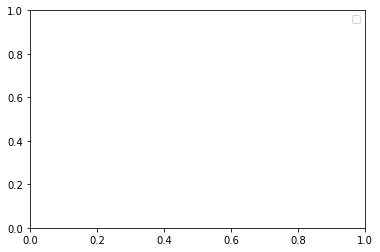

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.17      0.29      1333
           1       0.91      1.00      0.95     11221

    accuracy                           0.91     12554
   macro avg       0.95      0.58      0.62     12554
weighted avg       0.92      0.91      0.88     12554



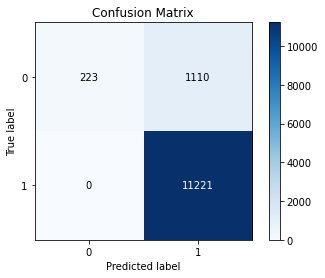

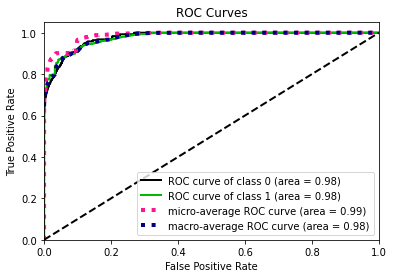

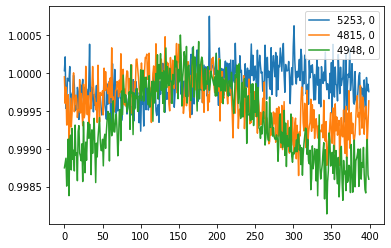

2022-02-07 10:12:06,930 - 666 - matplotlib.legend - WARNING: No handles with labels found to put in legend.


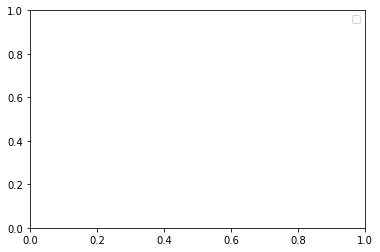

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.16      0.28      1333
           1       0.91      1.00      0.95     11221

    accuracy                           0.91     12554
   macro avg       0.95      0.58      0.61     12554
weighted avg       0.92      0.91      0.88     12554



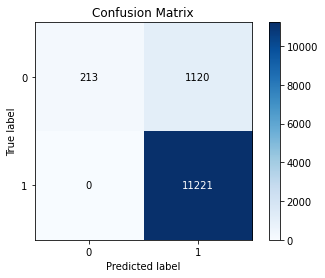

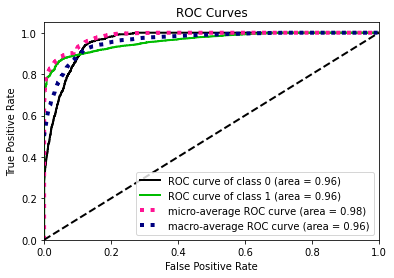

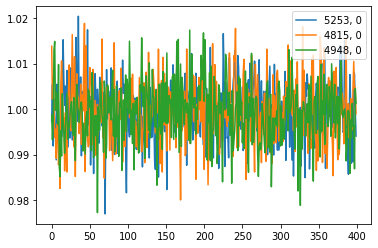

2022-02-07 10:12:38,729 - 666 - matplotlib.legend - WARNING: No handles with labels found to put in legend.


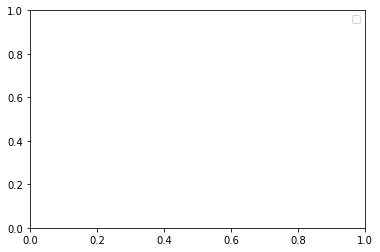

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.16      0.27      1333
           1       0.91      1.00      0.95     11221

    accuracy                           0.91     12554
   macro avg       0.95      0.58      0.61     12554
weighted avg       0.92      0.91      0.88     12554



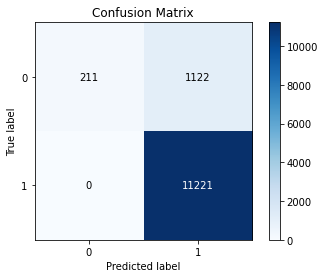

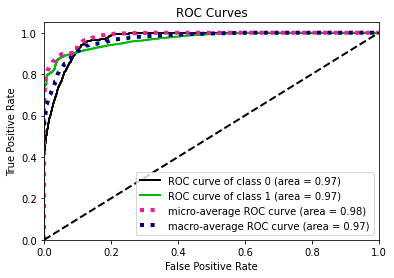

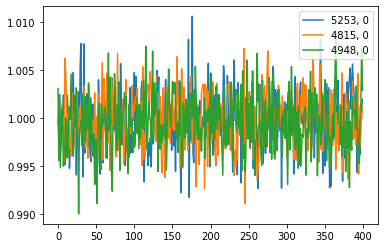

2022-02-07 10:13:10,257 - 666 - matplotlib.legend - WARNING: No handles with labels found to put in legend.


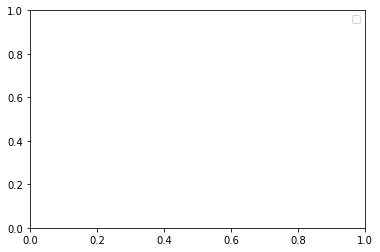

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.15      0.26      1333
           1       0.91      1.00      0.95     11221

    accuracy                           0.91     12554
   macro avg       0.95      0.57      0.60     12554
weighted avg       0.92      0.91      0.88     12554



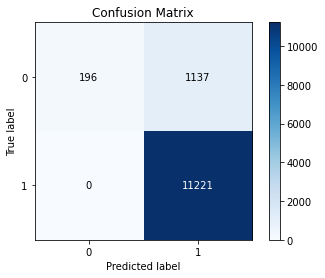

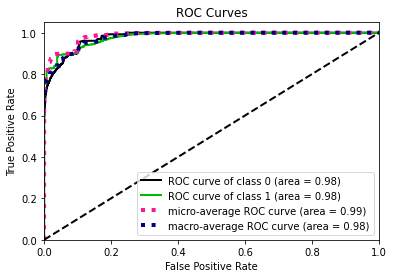

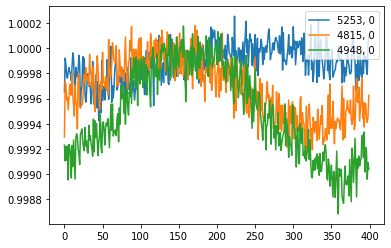

2022-02-07 10:13:42,296 - 666 - matplotlib.legend - WARNING: No handles with labels found to put in legend.


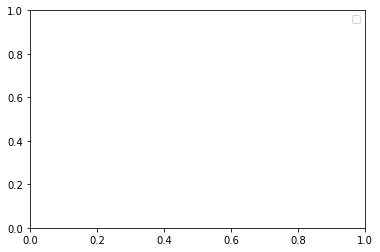

In [27]:
processed_test_data=[
 X_test_with_arrays_noise[0][0],
 X_test_with_arrays_noise[1][0],
 X_test_with_arrays_noise[2][0],
 X_test_with_arrays_noise[3][0],
 X_test_with_arrays_noise[4][0]]

processed_test_data = np.array(processed_test_data)

print(y_test.shape)
print(processed_test_data.shape)

for UBVRI in processed_test_data:
    evaluate_all('model_experiment_2.hdf5', UBVRI, y_test)

# Model 3 evaluation

(62770,)
(62770, 400, 1)
Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.71      0.78      6665
           1       0.97      0.99      0.98     56105

    accuracy                           0.96     62770
   macro avg       0.92      0.85      0.88     62770
weighted avg       0.96      0.96      0.96     62770



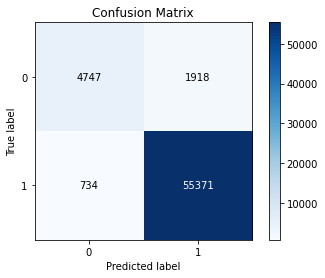

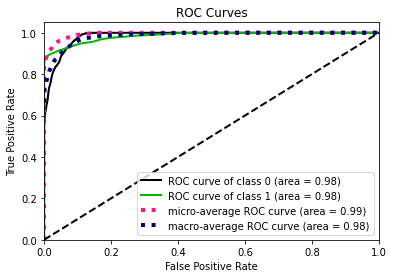

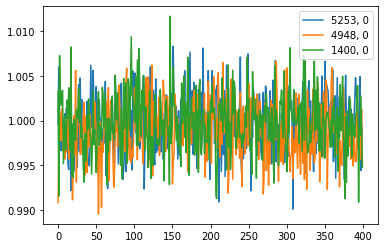

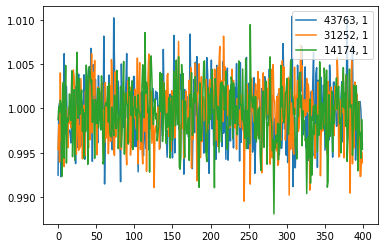

In [28]:
processed_test_data= np.concatenate((
 X_test_with_arrays_noise[0][0],
 X_test_with_arrays_noise[1][0],
 X_test_with_arrays_noise[2][0],
 X_test_with_arrays_noise[3][0],
 X_test_with_arrays_noise[4][0]))

y_test_mixed = pd.concat([y_test,
                            y_test, 
                            y_test, 
                            y_test,
                            y_test]) 
print(y_test_mixed.shape)
print(processed_test_data.shape)

evaluate_all('model_experiment_3.hdf5', processed_test_data, y_test_mixed)